# Obtain Datasets


<div style:"align=justify"> 
The first step is to obtain unstructure data that contains images of X-ray Chest uses Kaggle API.
</div>

In [1]:
!pip install kaggle --upgrade   # install and upgrade kaggle
!pip install tensorflow==2.4.0  # install 2.4.0 version of Tensorflow

Requirement already up-to-date: kaggle in /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages (1.5.10)


In [2]:
!echo '{"username":"jonahwinninghoff","key":"9f781c2f96e9b19527914536119f7f76"}' > ~/.kaggle/kaggle.json
!chmod 600 /home/dsxuser/.kaggle/kaggle.json

chmod: cannot access '/home/dsxuser/.kaggle/kaggle.json': No such file or directory


In [3]:
import kaggle

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [5]:
api.dataset_download_files('pranavraikokte/covid19-image-dataset', 
                           path='./',
                           force=True, 
                           quiet=False)

  2%|▏         | 3.00M/158M [00:00<00:05, 31.0MB/s]

100%|██████████| 158M/158M [00:01<00:00, 107MB/s]  

In [6]:
from zipfile import ZipFile          # Download and unzip images from kaggle API

zipped = 'covid19-image-dataset.zip'
datasets = 'datasets'

zf = ZipFile(zipped)
zf.extractall(datasets)
zf.close()

In [7]:
import os                            # Create a filesystem directory of images

images = []
for dirname, _, filenames in os.walk(datasets):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))

# Undertake Exploratory Data Analysis

In [8]:
words = ["The entire dataset has", str(len(images)), "different images."]

print(" ".join(words))

The entire dataset has 317 different images.


In [9]:
train = []                      # Separate training dataset from testing 
test = []
for i in range(len(images)):
    if "train" in images[i]:
        train.append(os.path.join(os.getcwd(),images[i]))
    else:
        test.append(os.path.join(os.getcwd(),images[i]))

    
        
a = str(len(train))             # Write the statement
b = str(len(test))
c = str(round(100*len(test)/(len(train)+len(test)),2))
        
words = ["Training dataset has",a, 
         "images while testing dataset has", 
         b, "images. That is, the testing dataset is", 
         c, "percent of the entire dataset."]

print(" ".join(words))

Training dataset has 251 images while testing dataset has 66 images. That is, the testing dataset is 20.82 percent of the entire dataset.


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow
import pathlib
import datetime
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [11]:
train_path = 'datasets/Covid19-dataset/train' # Construct pathlib necessary for Tensorflow
test_path = 'datasets/Covid19-dataset/test'

training = pathlib.Path(train_path)
testing = pathlib.Path(test_path)

In [12]:
batch_size = 10   # Read 10 images per
img_height = 200  # Size of every image
img_width = 200

train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory( # Training dataset
  training,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory( # Testing dataset
  testing,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


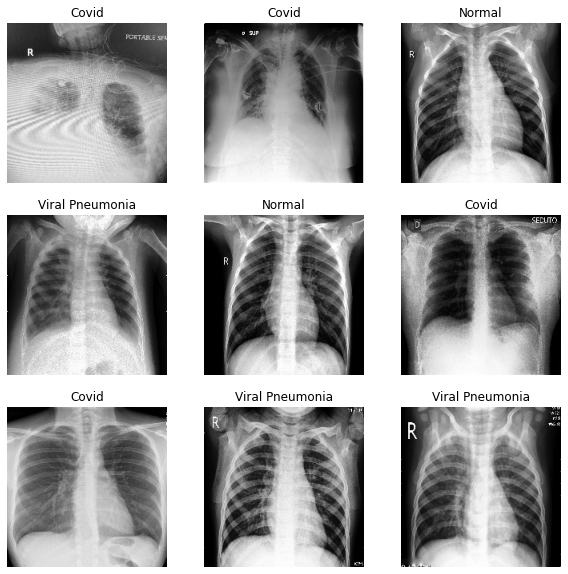

In [13]:
plt.figure(figsize=(10, 10))                          # Randomly select nine different images with label
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

The next task is to find each number of images for each type of lungh, average image, contrast between three images, image standard deviation, and eigenimages

In [14]:
training_normal_path = '/home/dsxuser/work/datasets/Covid19-dataset/train/Normal' # Normal lung file path
training_pneumonia_path = '/home/dsxuser/work/datasets/Covid19-dataset/train/Viral Pneumonia' # Virual Pneumonia file path
training_COVID_path = '/home/dsxuser/work/datasets/Covid19-dataset/train/Covid'   # COVID lung file path 


training_normal = pathlib.Path(training_normal_path)
training_pneumonia = pathlib.Path(training_pneumonia_path)
training_COVID = pathlib.Path(training_COVID_path)

In [15]:
N = len(list(training.glob('Normal/*')))          # Count total images for each type in training dataset
C = len(list(training.glob('Covid/*')))
P = len(list(training.glob('Viral Pneumonia/*')))

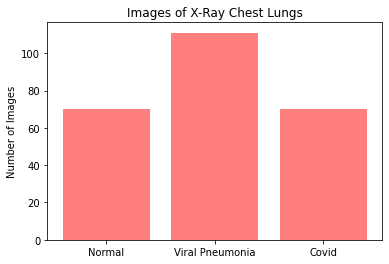

In [16]:
objects = ('Normal', 'Viral Pneumonia', 'Covid')  # Make a bar chart for this
y_pos = np.arange(len(objects))
performance = [N,C,P]

plt.bar(y_pos, performance, align='center', alpha=0.5, color='red')
plt.xticks(y_pos, objects)
plt.ylabel('Number of Images')
plt.title('Images of X-Ray Chest Lungs')

plt.show()

In [17]:
Normal = list(training.glob('Normal/*'))            # Create subsets of training dataset
Covid = list(training.glob('Covid/*'))
Pneumonia = list(training.glob('Viral Pneumonia/*'))

In [18]:
def matrix_image(path, number_of_list, size = (64, 64)):            # Create full matrix transformation function based on image pixels
    # iterating through each file
    for i in range(number_of_list):
        current_image = image.load_img(path[i], target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [19]:
normal = matrix_image(Normal,len(Normal))     # Transform all normal lung images into full matrix
pneum = matrix_image(Pneumonia,len(Pneumonia)) # Pneumonia
covid = matrix_image(Covid,len(Covid))         # Covid

In [20]:
def average_img(full_mat, size = (64, 64)): # Create the average image function
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    return mean_img

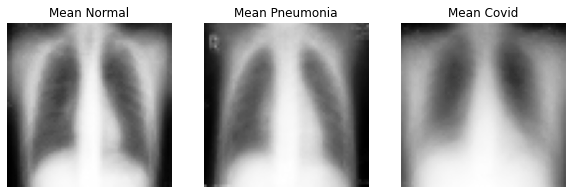

In [21]:
norm_mean = average_img(normal)
pneu_mean = average_img(pneum)
covi_mean = average_img(covid)

thelist = [norm_mean, pneu_mean, covi_mean]
label = ["Mean Normal", "Mean Pneumonia","Mean Covid"]

plt.figure(figsize=(10, 10))                          # Average image of each type
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(thelist[i],cmap='Greys_r')
        plt.title(label[i])
        plt.axis("off")

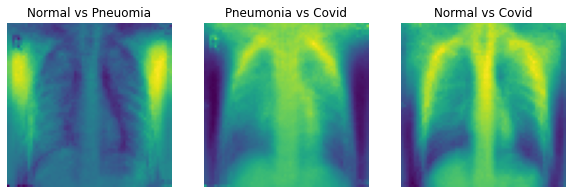

In [22]:
contrast_norm_pneu = norm_mean - pneu_mean             # Calculate difference between two types of lungs
contrast_pneu_covi = pneu_mean - covi_mean
contrast_norm_covi = norm_mean - covi_mean

thelist = [contrast_norm_pneu,contrast_pneu_covi,contrast_norm_covi]
label = ["Normal vs Pneuomia", "Pneumonia vs Covid","Normal vs Covid"]

plt.figure(figsize=(10, 10))                          # Contrast between two types
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(thelist[i])
        plt.title(label[i])
        plt.axis("off")

In [23]:
def sd_img(full_mat, size = (64, 64)): # Create the standard deviation image function
    # calculate the stdev
    sd_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    sd_img = sd_img.reshape(size)
    return sd_img

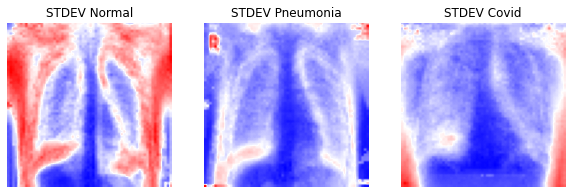

In [24]:
norm_sd = sd_img(normal)
pneu_sd = sd_img(pneum)
covi_sd = sd_img(covid)

thelist = [norm_sd, pneu_sd, covi_sd]
label = ["STDEV Normal", "STDEV Pneumonia","STDEV Covid"]

plt.figure(figsize=(10, 10))                          # Standard deviation image of each type
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(thelist[i],cmap='bwr')
        plt.title(label[i])
        plt.axis("off")

# Increase data noise
Enable the Deep Learning more resistent to out-of-sample errors.

In [25]:
data_noise = keras.Sequential([                                        # Automate to modify shape of every image
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                input_shape=(img_height,
                                                            img_width,
                                                            3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])

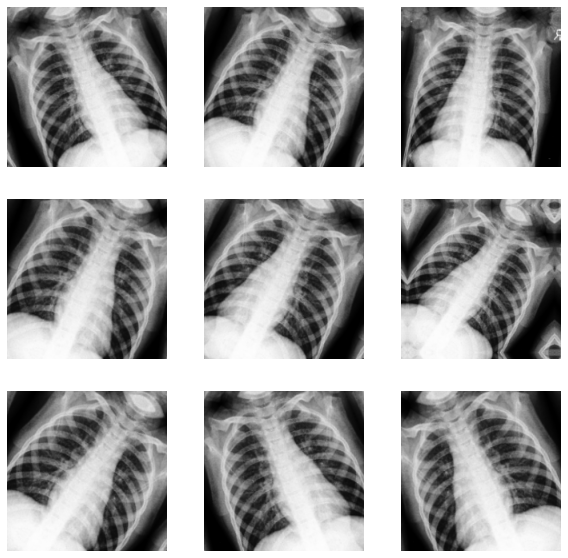

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    noise_images = data_noise(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(noise_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Use Convolutional Neural Network to train image classification

In [27]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) # Standardize the data

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

words = ["The range of pixel values is from", str(np.min(first_image)),"to",str(np.max(first_image)),"instead between 0 and 255."]

print(" ".join(words))

The range of pixel values is from 0.0 to 1.0 instead between 0 and 255.


In [29]:
AUTOTUNE = tensorflow.data.AUTOTUNE
train_ds1 = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE) # Increase speed of data processing

In [30]:
num_classes = 3

model = Sequential([                                       # Build deep neural network using Keras API
  data_noise,                                              # Make data more noise
  layers.experimental.preprocessing.Rescaling(1./255),     # Standardize image
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)       

In [32]:
opt = tensorflow.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")


model.compile(optimizer=opt,                            # Write the model compilation
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
epochs = 20                                       # Choose the value of learning rate and number of epochs

tensorflow.random.set_seed(133)                   # Enable this research to be reproducible

result = model.fit(
  train_ds,
  validation_data=test_ds,
  batch_size=batch_size,
  epochs=epochs)

Epoch 1/20
26/26 [==============================] - 26s 904ms/step - loss: 1.1200 - accuracy: 0.4535 - val_loss: 0.8422 - val_accuracy: 0.5303
Epoch 2/20
26/26 [==============================] - 24s 881ms/step - loss: 0.6463 - accuracy: 0.6998 - val_loss: 0.8186 - val_accuracy: 0.6364
Epoch 3/20
26/26 [==============================] - 24s 874ms/step - loss: 0.4170 - accuracy: 0.8453 - val_loss: 0.5154 - val_accuracy: 0.7424
Epoch 4/20
26/26 [==============================] - 24s 882ms/step - loss: 0.4158 - accuracy: 0.8470 - val_loss: 0.4423 - val_accuracy: 0.7727
Epoch 5/20
26/26 [==============================] - 24s 878ms/step - loss: 0.3638 - accuracy: 0.8589 - val_loss: 0.4198 - val_accuracy: 0.8182
Epoch 6/20
26/26 [==============================] - 25s 913ms/step - loss: 0.3180 - accuracy: 0.8564 - val_loss: 0.6072 - val_accuracy: 0.6667
Epoch 7/20
26/26 [==============================] - 24s 882ms/step - loss: 0.3037 - accuracy: 0.8531 - val_loss: 0.4154 - val_accuracy: 0.8636

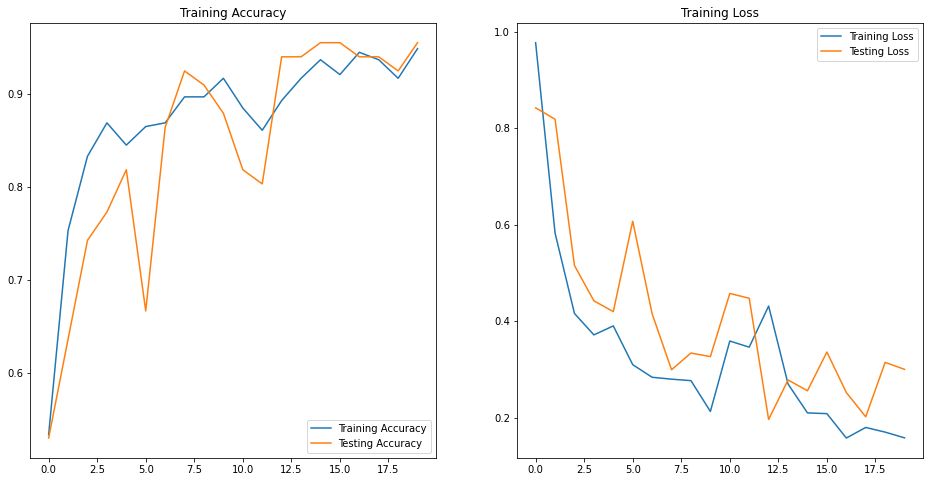

In [34]:
acc = result.history['accuracy']
tes_acc = result.history['val_accuracy']
loss = result.history['loss']
tes_loss = result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, tes_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, tes_loss,label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [35]:
score = model.evaluate(test_ds, verbose=0)    # Undertake cross-validation evaluation

statement = ["As indicated by cross validation, the image classification performs well. Its accuracy is", 
             str(round(score[1]*100,2)),"percent and its loss is",
             str(round(score[0],2)),"that this result is interpreted as a model at healthy level."]

print(" ".join(statement))

As indicated by cross validation, the image classification performs well. Its accuracy is 95.45 percent and its loss is 0.3 that this result is interpreted as a model at healthy level.


# Save this model

In [36]:
model.save('Original_One.h5') # Save this model

In [37]:
model1=keras.models.load_model('Original_One.h5') # Test if this model can load
print(model1.evaluate(test_ds,verbose=0))

[0.30015313625335693, 0.9545454382896423]


# Features need to change in order to improve accuracy

In [38]:
!pip install tensorflow==2.1.0

In [39]:
import os                            # Create a filesystem directory of images

images = []
for dirname, _, filenames in os.walk(datasets):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))

train = []                      # Separate training dataset from testing again
test = []
for i in range(len(images)):
    if "train" in images[i]:
        train.append(os.path.join(os.getcwd(),images[i]))
    else:
        test.append(os.path.join(os.getcwd(),images[i]))

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array  # Need ImageDataGenerator for feature engineering

In [41]:
datagen = ImageDataGenerator(         # This setting is similar to data_noise layer
        zoom_range=0.1,
        rescale=1./255,
        rotation_range=0.1,
        horizontal_flip=True,
        brightness_range=(0.2, 0.8))  # And random brightness adds

test_datagen = ImageDataGenerator(    # For test set, no additional image augmentations
        rescale=1./255)

In [42]:
train_path = 'datasets/Covid19-dataset/train' # Construct pathlib necessary for Tensorflow again
test_path = 'datasets/Covid19-dataset/test'

training = pathlib.Path(train_path)
testing = pathlib.Path(test_path)

In [43]:
train_ds = datagen.flow_from_directory( # Training dataset using datagen
  training,
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_datagen.flow_from_directory( # Testing dataset using test_datagen
  testing,
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [44]:
num_classes = 3

new_model = Sequential([                                       # Eliminate data_noise and normalization because ImageDataGenerator has both                                                 
  tensorflow.keras.Input(
    shape=(img_height,img_width,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(num_classes,activation='softmax')                # Remove one dense layer to strengthen loss convergence
])

In [45]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 64)       

In [46]:
opt = tensorflow.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")


new_model.compile(optimizer=opt,                            # Write the model compilation
              loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
epochs=20

tensorflow.random.set_seed(144)                   # Enable this research to be reproducible as well

result=new_model.fit(train_ds,
         validation_data=test_ds,
         batch_size=batch_size,
         epochs=epochs)

Epoch 1/20
26/26 [==============================] - 30s 1s/step - loss: 1.0596 - accuracy: 0.4588 - val_loss: 0.8101 - val_accuracy: 0.6061
Epoch 2/20
26/26 [==============================] - 27s 1s/step - loss: 0.7067 - accuracy: 0.7713 - val_loss: 0.5999 - val_accuracy: 0.7576
Epoch 3/20
26/26 [==============================] - 27s 1s/step - loss: 0.4886 - accuracy: 0.8152 - val_loss: 0.7327 - val_accuracy: 0.6667
Epoch 4/20
26/26 [==============================] - 28s 1s/step - loss: 0.4457 - accuracy: 0.8524 - val_loss: 0.4407 - val_accuracy: 0.8333
Epoch 5/20
26/26 [==============================] - 28s 1s/step - loss: 0.3435 - accuracy: 0.8887 - val_loss: 0.4358 - val_accuracy: 0.8182
Epoch 6/20
26/26 [==============================] - 27s 1s/step - loss: 0.2486 - accuracy: 0.8896 - val_loss: 0.3901 - val_accuracy: 0.8485
Epoch 7/20
26/26 [==============================] - 28s 1s/step - loss: 0.2878 - accuracy: 0.8719 - val_loss: 0.3116 - val_accuracy: 0.8788
Epoch 8/20
26/26 [==

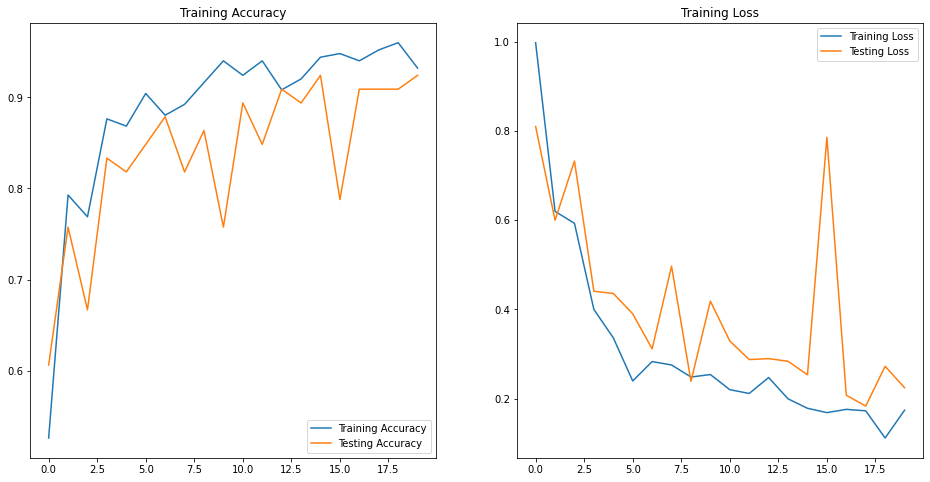

In [48]:
acc = result.history['accuracy']
tes_acc = result.history['val_accuracy']
loss = result.history['loss']
tes_loss = result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, tes_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, tes_loss,label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [49]:
score = new_model.evaluate(test_ds, verbose=0)    # Undertake cross-validation evaluation

statement = ["As indicated by cross validation, the image classification performs well. Its accuracy is", 
             str(round(score[1]*100,2)),"percent and its loss is",
             str(round(score[0],2)),"that this result is excellent. Not only that, the loss convergence exists."]

print(" ".join(statement))

As indicated by cross validation, the image classification performs well. Its accuracy is 92.42 percent and its loss is 0.22 that this result is excellent. Not only that, the loss convergence exists.


In [50]:
new_model.save('saved_model.h5') # Save this model

In [51]:
model2=keras.models.load_model('saved_model.h5') # Test if this model.h5 can load

In [52]:
model2.evaluate(test_ds,verbose=0)

[0.22441892325878143, 0.9242424368858337]

# Prepare New Model for Deployment

In [53]:
!pip install watson-machine-learning-client-V4

In [54]:
!tar -zcvf saved_model.h5.tgz saved_model.h5

saved_model.h5


In [55]:
from ibm_watson_machine_learning import APIClient                          # Unlock my Watson Machine Learning using API
wml_credentials = {"apikey":"********************",
                   "url": "https://us-south.ml.cloud.ibm.com"
   }
wml_client = APIClient(wml_credentials)

2021-02-14 01:24:43,537 - ibm_watson_machine_learning.wml_client_error - WARNING - Deployment creation failed for deployment id: 40bc3668-34e7-4a85-a0e7-cfe379589c63. Errors: [{'code': 'invalid_model_archive', 'message': "Keras model load failed with error: ('Keyword argument not understood:', 'groups')", 'target': {'type': 'none', 'name': 'none'}, 'more_info': 'none'}]


In [56]:
space_uid='3c63272d-0e8e-4bf8-9916-68fbd870da94' # Copy my space id
wml_client.set.default_space(space_uid)   # Automate to unlock the specific deployment area

'SUCCESS'

In [57]:
print(wml_client.software_specifications.list()) # Check the supported framework

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029a-cc97-56da-b8e0-39c3880dbbe7  base
tensorflow_2.1-py3.6           1eb25b8

#### The Tensorflow_2.1-py3.7 is chosen for deployment.

In [58]:
software_spec_id =  wml_client.software_specifications.get_id_by_name('default_py3.7')
print(software_spec_id)

e4429883-c883-42b6-87a8-f419d64088cd


In [59]:
model_props = {                                                                  
wml_client.repository.ModelMetaNames.NAME:"X_ray chest classifer",               # Let name it that
wml_client.repository.ModelMetaNames.TYPE:"tensorflow_2.1",                      # Let it be tensorflow_2.1
wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_id } 


In [60]:
model_details = wml_client.repository.store_model(model="saved_model.h5.tgz",meta_props=model_props)
published_model_uid = wml_client.repository.get_model_uid(model_details)

In [61]:
import json

published_model_uid = wml_client.repository.get_model_uid(model_details)
model_details = wml_client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "software_spec": {
      "id": "e4429883-c883-42b6-87a8-f419d64088cd",
      "name": "default_py3.7"
    },
    "type": "tensorflow_2.1"
  },
  "metadata": {
    "created_at": "2021-02-14T01:24:22.950Z",
    "id": "194b4d8c-0ef1-42c8-8262-30e926f07dc0",
    "modified_at": "2021-02-14T01:24:25.082Z",
    "name": "X_ray chest classifer",
    "owner": "IBMid-55000A4SMM",
    "space_id": "3c63272d-0e8e-4bf8-9916-68fbd870da94"
  },
  "system": {
    "warnings": []
  }
}


In [62]:
metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Deployment of external Tensorflow model",
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [63]:
wml_client.deployments.list() # This list should be emptied before it deploys.

------------------------------------  ---------------------------------------  ------  ------------------------
GUID                                  NAME                                     STATE   CREATED
fc1d4638-9de7-4e10-aae9-4cbccf9c99ff  Deployment of external Tensorflow model  failed  2021-02-14T01:04:42.390Z
190593c8-cf64-4153-b257-aa10ebb0e6b6  Deployment of external Tensorflow model  failed  2021-02-14T00:05:53.140Z
------------------------------------  ---------------------------------------  ------  ------------------------


# Start deploying this model

In [64]:
created_deployment = wml_client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '194b4d8c-0ef1-42c8-8262-30e926f07dc0' started

#######################################################################################


initializing..
failed

--------------------------
Deployment creation failed
--------------------------


Keras model load failed with error: ('Keyword argument not understood:', 'groups')


WMLClientError: Deployment creation failed for deployment id: 40bc3668-34e7-4a85-a0e7-cfe379589c63. Errors: [{'code': 'invalid_model_archive', 'message': "Keras model load failed with error: ('Keyword argument not understood:', 'groups')", 'target': {'type': 'none', 'name': 'none'}, 'more_info': 'none'}]